
🔵 Training model without dropout



🔴 Training model with dropout


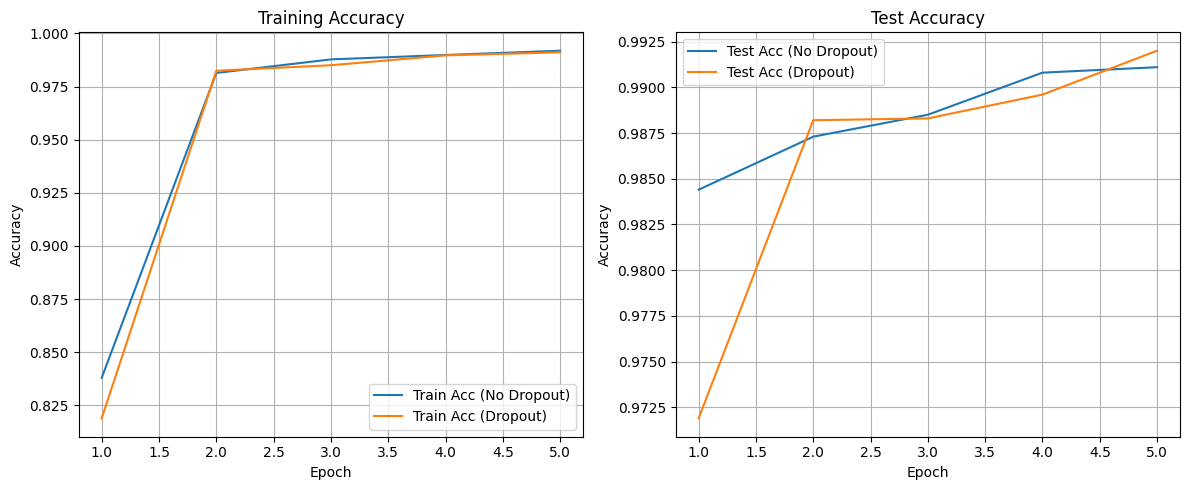

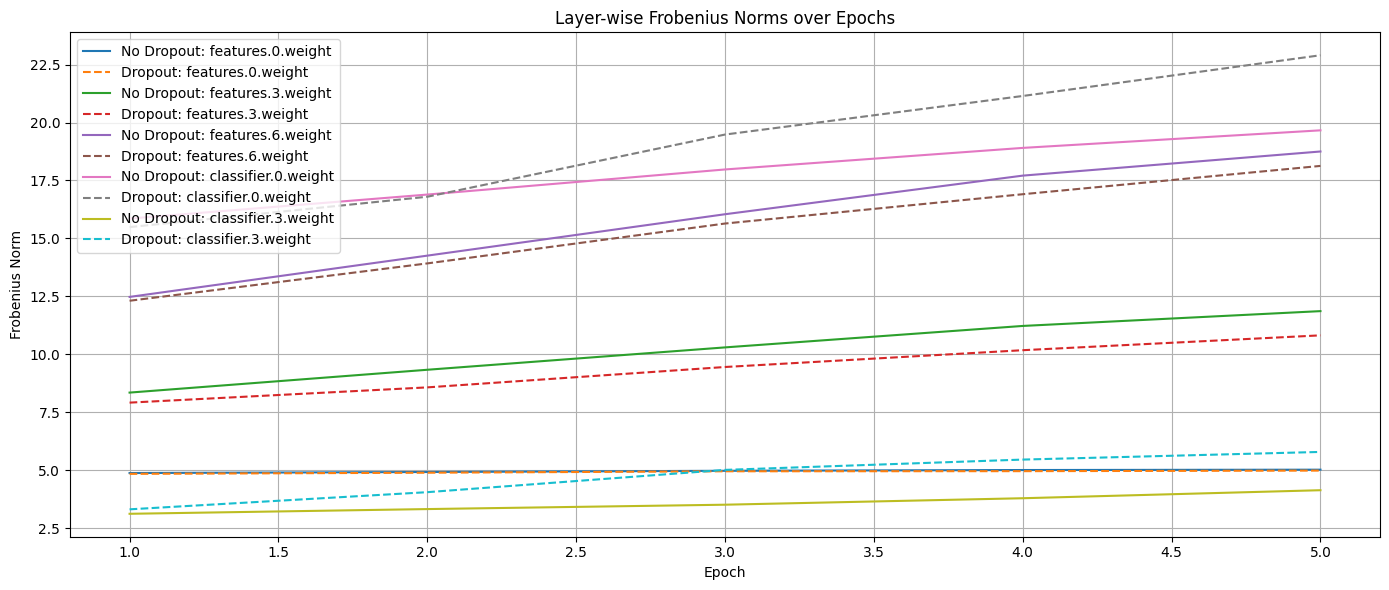

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# VGG11 with optional dropout
class VGG11(nn.Module):
    def __init__(self, num_classes=10, use_dropout=False):
        super(VGG11, self).__init__()
        dropout = 0.5 if use_dropout else 0.0
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Frobenius norm per layer
def compute_frobenius_norm_per_layer(model):
    norms = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            norms[name] = torch.norm(param.view(-1), p=2).item()
    return norms

# Train function
def train_model(model, optimizer, train_loader, test_loader, epochs=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_acc_list, test_acc_list = [], []
    frob_norms_by_layer = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            pbar.set_postfix(loss=loss.item())
        train_acc_list.append(correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        test_acc_list.append(correct / total)

        frob_norms_by_layer.append(compute_frobenius_norm_per_layer(model))

    return train_acc_list, test_acc_list, frob_norms_by_layer

# Plot layer-wise Frobenius norms
def plot_frobenius_norms(layer_names, norm_history1, norm_history2, label1, label2):
    plt.figure(figsize=(14, 6))
    for layer in layer_names:
        vals1 = [epoch[layer] for epoch in norm_history1]
        vals2 = [epoch[layer] for epoch in norm_history2]
        plt.plot(range(1, len(vals1)+1), vals1, label=f"{label1}: {layer}")
        plt.plot(range(1, len(vals2)+1), vals2, linestyle='--', label=f"{label2}: {layer}")
    plt.xlabel("Epoch")
    plt.ylabel("Frobenius Norm")
    plt.title("Layer-wise Frobenius Norms over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train model without dropout
print("\n🔵 Training model without dropout")
model_no_dropout = VGG11(use_dropout=False)
optimizer_no = optim.Adam(model_no_dropout.parameters(), lr=0.001)
acc_no, test_acc_no, frob_no = train_model(model_no_dropout, optimizer_no, train_loader, test_loader, epochs=5, device=device)

# Train model with dropout
print("\n🔴 Training model with dropout")
model_dropout = VGG11(use_dropout=True)
optimizer_do = optim.Adam(model_dropout.parameters(), lr=0.001)
acc_do, test_acc_do, frob_do = train_model(model_dropout, optimizer_do, train_loader, test_loader, epochs=5, device=device)

# Accuracy plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), acc_no, label="Train Acc (No Dropout)")
plt.plot(range(1, 6), acc_do, label="Train Acc (Dropout)")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), test_acc_no, label="Test Acc (No Dropout)")
plt.plot(range(1, 6), test_acc_do, label="Test Acc (Dropout)")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Frobenius norm plots
layers_to_plot = [
    'features.0.weight',    # Conv1
    'features.3.weight',    # Conv2
    'features.6.weight',    # Conv3
    'classifier.0.weight',  # FC1
    'classifier.3.weight'   # FC2
]
plot_frobenius_norms(layers_to_plot, frob_no, frob_do, "No Dropout", "Dropout")
